In [1]:
library(FlashGraphR)
fg.set.conf("/mnt/nfs2/zhengda/FlashX-stable/matrix/conf/run_test-EM.txt")

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: Rcpp
Loading required package: FlashR
Loading required package: RSpectra

Attaching package: ‘FlashR’

The following objects are masked from ‘package:base’:

    cbind, pmax, pmin, rbind



In [2]:
load(file="/mnt/nfs2/zhengda/pg-tmp1.Rdata")
load(file="/mnt/nfs2/zhengda/pg-tmp2.Rdata")
svals <- sqrt(c(evals1, evals2))[1:11]
print(svals)

right1 <- fm.get.dense.matrix("pg-tmp1.mat")
right2 <- fm.get.dense.matrix("pg-tmp2.mat")
right2 <- right2[,1:3]
right <- cbind(right1, right2)
print(dim(right))

left1 <- fm.get.dense.matrix("pg-tmp1-left.mat")
left2 <- fm.get.dense.matrix("pg-tmp2-left.mat")
left <- cbind(left1, left2)

 [1] 13421.905 12483.199 11748.237 10663.093 10480.413  9781.916  9590.699
 [8]  9589.698  9272.565  9107.523  8973.249
[1] 3343715215         11


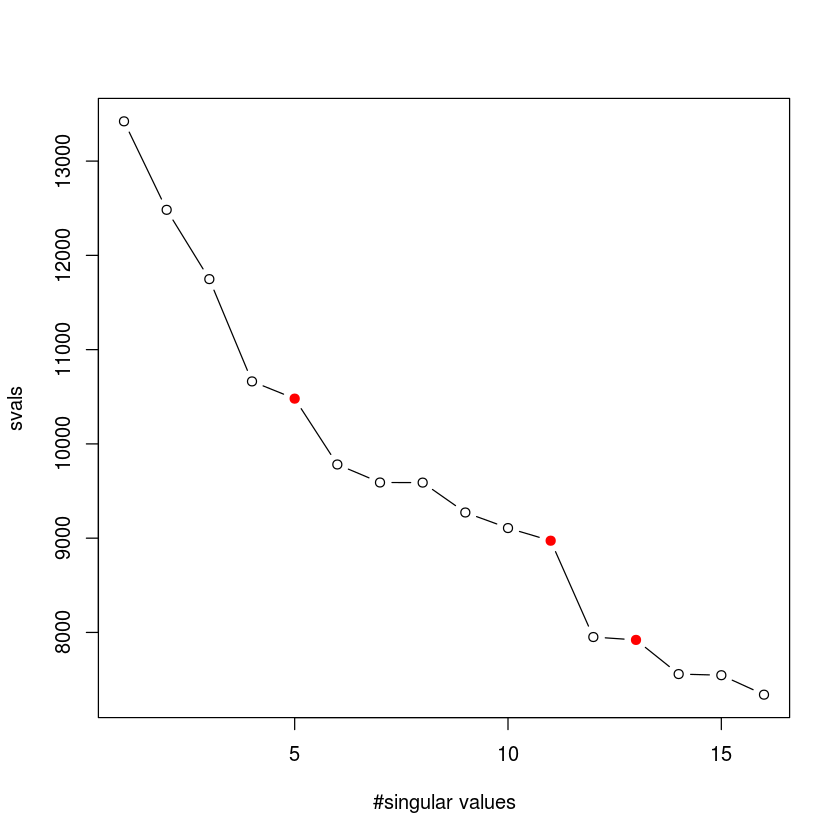

In [3]:
evals <- c(evals1, evals2)
getElbows <- function(d, n = 3, threshold = FALSE)
{
  if (is.unsorted(-d))
    stop("d must be sorted decreasingly!")

  if (!is.logical(threshold))
    d <- d[d > threshold]

  p <- length(d)
  if (p == 0)
    stop(paste("d must have elements that are larger than the threshold ",
               threshold), "!", sep="")

  lq <- rep(0.0, p)                     # log likelihood, function of q
  for (q in 1:p) {
    mu1 <- mean(d[1:q])
    mu2 <- mean(d[-(1:q)])              # = NaN when q = p
    sigma2 <- (sum((d[1:q] - mu1)^2) + sum((d[-(1:q)] - mu2)^2)) /
      (p - 1 - (q < p))
    lq[q] <- sum( dnorm(  d[1:q ], mu1, sqrt(sigma2), log=TRUE) ) +
      sum( dnorm(d[-(1:q)], mu2, sqrt(sigma2), log=TRUE) )
  }

  q <- which.max(lq)
  if (n > 1 && q < p) {
    return(c(q, q + getElbows(d[(q+1):p], n-1)))
  } else {
    return(q)
  }
}

cols <- rep("black", length(evals))
cols[getElbows(sqrt(evals))] <- "red"
pch <- rep(1, length(evals))
pch[getElbows(sqrt(evals))] <- 19
plot(sqrt(evals), type="b", xlab="#singular values", ylab = "svals", col=cols, pch=pch)

In [4]:
if (is.null(left)) {
    fg <- fg.get.graph("pg-tmp-lcc")
    spm <- fg.get.sparse.matrix(fg)
    deg <- fg.degree(fg, mode="both")/(2*fg.vcount(fg) - 1)
}

In [5]:
if (is.null(left)) {
    rescale <- function(x) {
        if (fm.is.vector(x))
        x <- fm.as.matrix(x)
        scal <- sqrt(colSums(x * x))
        x <- fm.mapply.row(x, scal, fm.bo.div)
    }

    right1.tmp <- fm.conv.store(right1, in.mem=TRUE)
    left1 <- spm %*% right1.tmp + fm.mapply.col(fm.as.matrix(right1.tmp), deg, "*")
    left1 <- fm.conv.store(rescale(left1), in.mem = FALSE, name="pg-tmp1-left.mat")

    right1.tmp <- NULL
    gc()

    right2.tmp <- fm.conv.store(right2, in.mem=TRUE)
    left2 <- spm %*% right2.tmp + fm.mapply.col(fm.as.matrix(right2.tmp), deg, "*")
    left2 <- fm.conv.store(rescale(left2), in.mem = FALSE, name="pg-tmp2-left.mat")

    right2.tmp <- NULL
    gc()

    left <- cbind(left1, left2)
}

In [6]:
data <- cbind(left, right)
data <- fm.mapply.row(data, sqrt(c(svals, svals)), "*")
r <- sqrt(fm.agg.mat(data * data, 1, "+"))
data <- data[r > 1e-5, ]
dim(data)

[1] 15774334       22

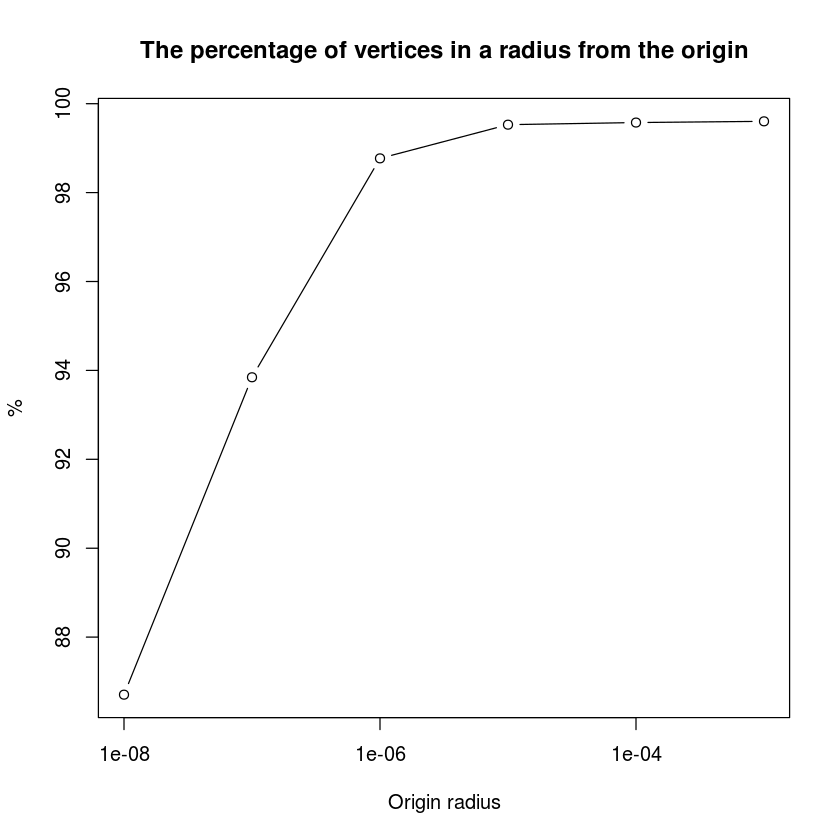

In [7]:
res <- list()
origin.radius <- c(1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3)
for (val in origin.radius) {
    res <- c(res, r < val)
}
res <- fm.cbind.list(res)
origin.ratio <- as.vector(colSums(as.double(res)))/nrow(res)
plot(x=origin.radius, y=origin.ratio * 100, type="b", xlab="Origin radius", ylab="%",
     main="The percentage of vertices in a radius from the origin", log="x")

In [8]:
range(data[,1])

[1] -1.135741e+00  1.169345e-15

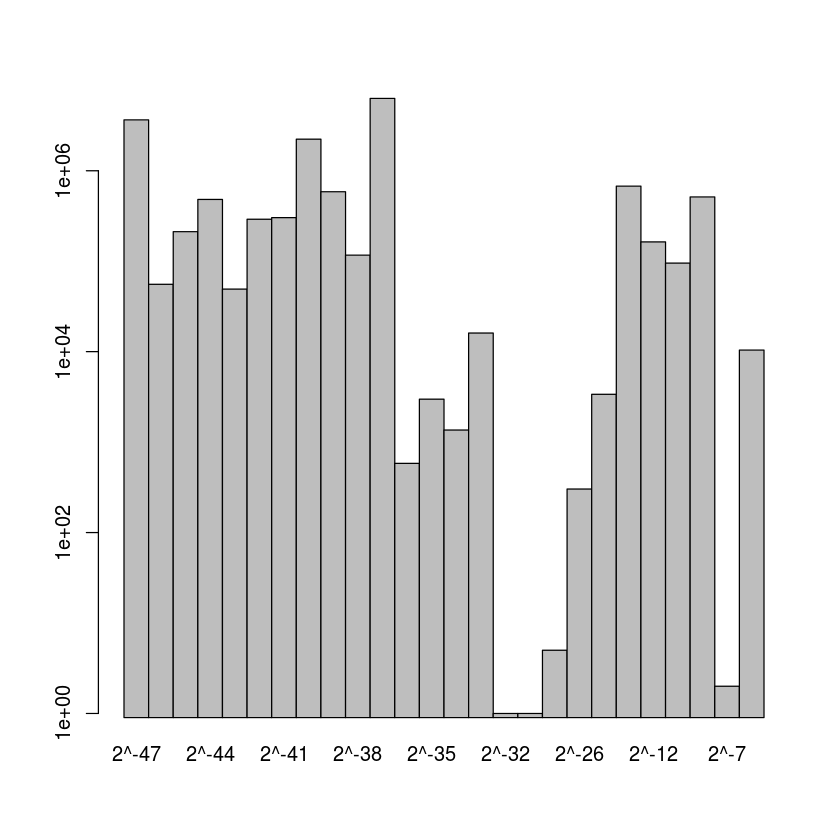

In [20]:
fm.hist(-data[,1] + 1e-14, breaks="exp", log="y")

In [9]:
range(data[,12])

[1] -1.079362e+00  1.746318e-12

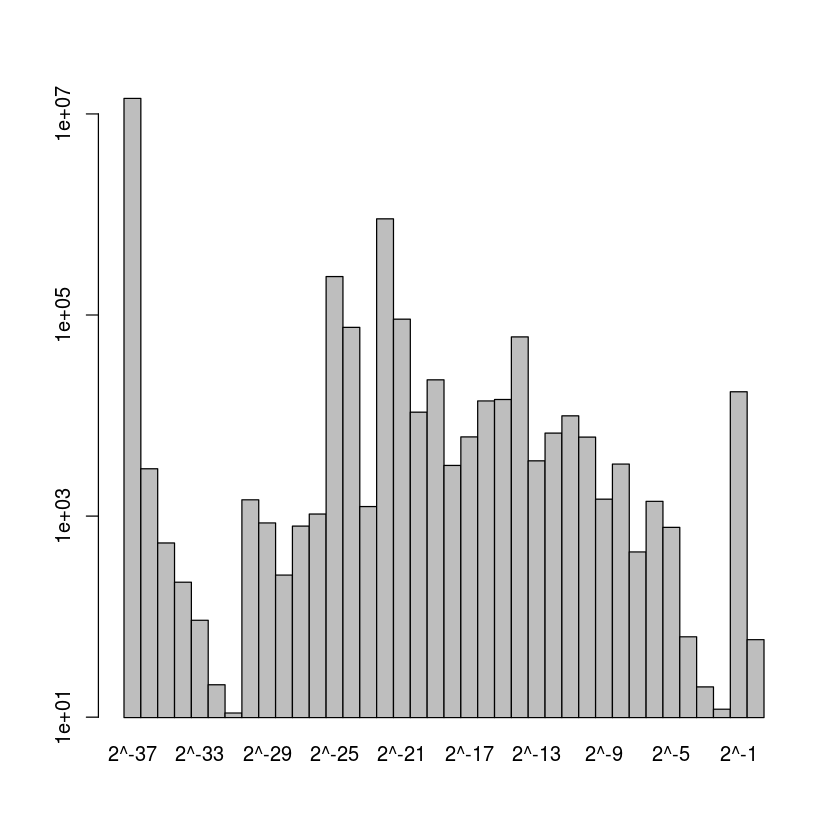

In [22]:
fm.hist(-data[,12] + 1e-11, breaks="exp", log="y")

In [24]:
X.in <- left[,1] * sqrt(svals[1])
X.out <- right[,1] * sqrt(svals[1])
X.in <- fm.conv.store(X.in, in.mem=TRUE)
X.out <- fm.conv.store(X.out, in.mem=TRUE)
m <- c(fm.conv.FM2R(mean(X.in)), fm.conv.FM2R(mean(X.out)))
m

[1] -4.346784e-06 -4.593479e-06

In [25]:
norm2 <- function(x) sqrt(sum(x*x))
m1 <- rep(norm2(m)/sqrt(2), 2)
cos <- sum(m*m1)/norm2(m)/norm2(m1)
sin <- -sqrt(1-cos*cos)
# This rotates clock-wise.
proj <- matrix(c(cos,sin,-sin,cos), 2, 2)

coo <- cbind(fm.as.matrix(X.in), fm.as.matrix(X.out))
coo <- fm.materialize(coo %*% proj)

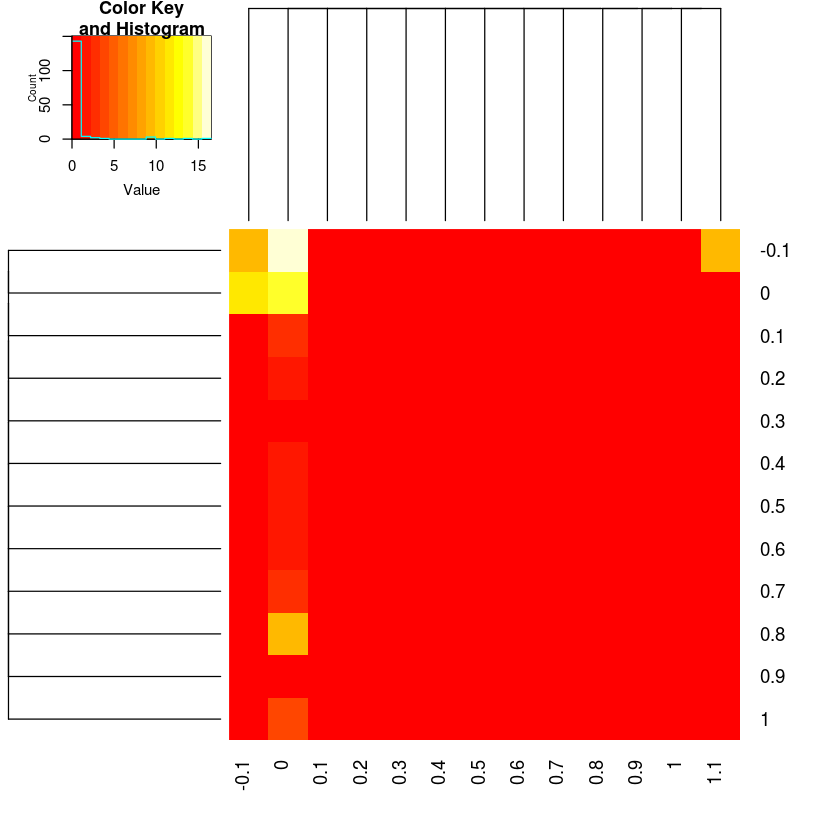

In [35]:
library(gplots)
coo1 <- coo[r > 1e-5,]
fm.heatmap(coo1, 10, logval=TRUE)

In [10]:
library(fpc)
library(ClusterR)
rdata <- as.matrix(data)
pk <- list()
for (k in 2:15) {
    init.res <- KMeans_rcpp(rdata, k, max_iters = 1, initializer="kmeans++")
    X <- rbind(init.res$centroids, rdata)
    pk[[k]] <- pamk(X, krange=k, usepam=FALSE, critout=TRUE, medoids=1:k)
}

Loading required package: gtools

Attaching package: ‘gtools’

The following object is masked from ‘package:igraph’:

    permute

Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

2  clusters  0.4534198 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

3  clusters  0.9283453 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

4  clusters  0.9041763 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

5  clusters  0.8654094 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

6  clusters  0.8690088 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

7  clusters  0.8881197 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

8  clusters  0.900345 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

9  clusters  0.8831678 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

10  clusters  0.8091552 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

11  clusters  0.8666063 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

12  clusters  0.8374025 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

13  clusters  0.7881002 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

14  clusters  0.8140166 


Warning message in if (medoids.x) ox <- x else if (keep.data) stop("when 'medoids.x' is FALSE, 'keep.data' must be too"):
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) data <- x:
“the condition has length > 1 and only the first element will be used”Warning message in if (medoids.x) ox[res$imed, , drop = FALSE]:
“the condition has length > 1 and only the first element will be used”Warning message in if (keep.data) r$data <- data:
“the condition has length > 1 and only the first element will be used”

15  clusters  0.8461598 


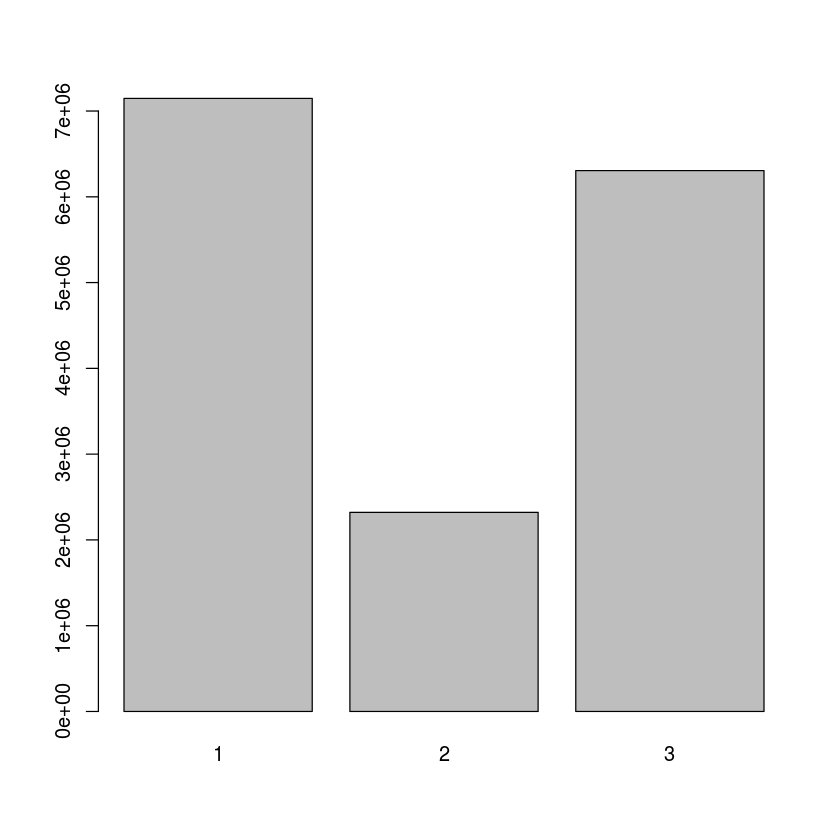

In [48]:
cnt3 <- table(pamout$pamobject$clustering)
barplot(cnt3)

-2.033544e-03,-8.197186e-04,-2.750254e-03,-2.228284e-03,8.352782e-04,2.046633e-03,-1.620662e-03,-1.284090e-03,-2.156131e-07,-2.483186e-03,⋯,-2.359749e-05,-1.049748e-03,-2.144613e-03,8.029344e-04,1.298564e-03,-1.060137e-03,-1.225971e-03,-3.398652e-05,-7.051630e-04,-3.037288e-04
-1.111829e-16,-1.240235e-12,3.171545e-16,-1.237447e-15,6.773415e-16,9.944659e-17,-5.684143e-12,2.227473e-12,-5.156206e-02,9.751186e-16,⋯,-1.493303e-14,4.780483e-18,-1.717828e-17,1.067889e-17,2.381633e-18,-8.640666e-14,3.386860e-14,-8.220385e-04,1.599913e-17,8.171739e-17
-1.189931e-11,-4.435455e-02,2.901301e-13,9.680923e-15,-1.409416e-15,-8.271862e-12,8.062679e-12,2.476108e-15,1.362768e-12,1.511444e-13,⋯,-9.141259e-05,-5.245917e-15,7.426807e-18,9.241793e-19,-1.203058e-14,4.169050e-15,4.374971e-17,6.357707e-16,-1.114549e-14,-1.344195e-14


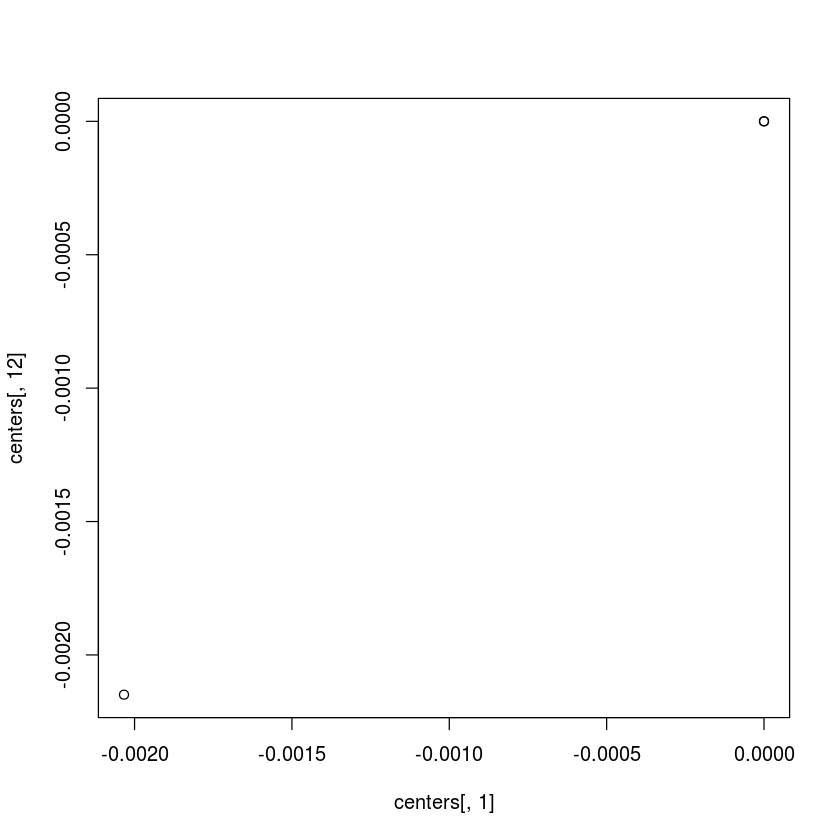

In [49]:
clustering <- fm.as.vector(pamout$pamobject$clustering)
centers <- as.matrix(fm.groupby(data, 2, fm.as.factor(clustering), "+")/as.matrix(cnt3))
centers
plot(x=centers[,1], y=centers[,12])

In [39]:
res7 <- kmeans(as.matrix(data), centers = 7)

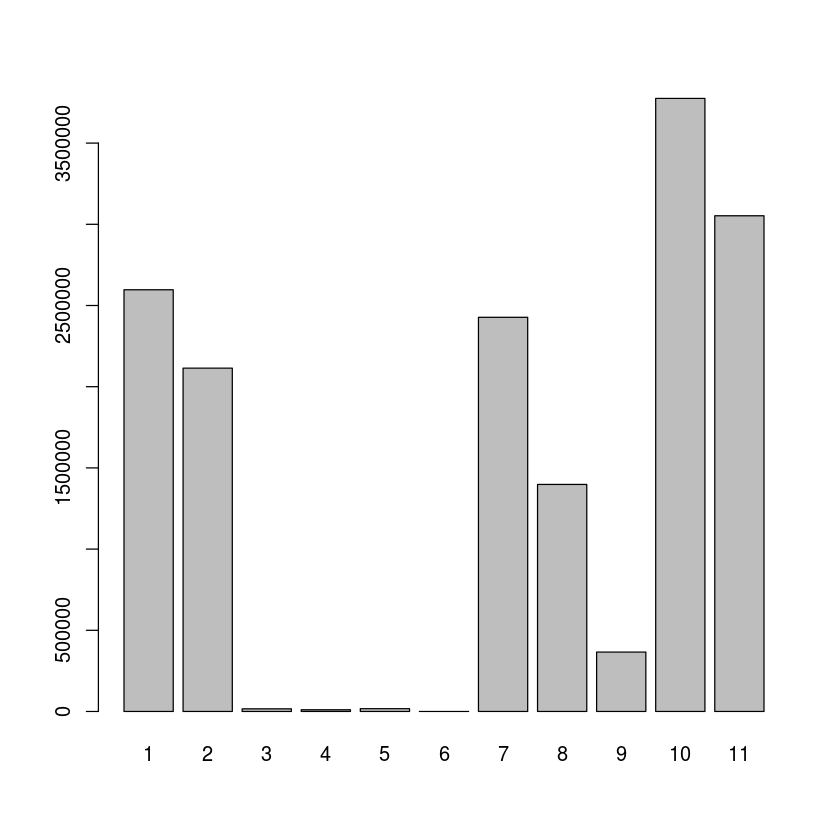

In [51]:
cnt7 <- table(res7$cluster)
barplot(cnt7)

-2.782562e-16,-1.751978e-11,-7.179254e-03,-5.681500e-03,2.120787e-03,4.924687e-03,5.774539e-04,-3.171174e-03,-4.609238e-02,-6.248136e-03,⋯,-1.571522e-12,-2.886082e-03,-5.649449e-03,2.108219e-03,3.165881e-03,3.791882e-04,-3.147087e-03,-8.239909e-04,-1.934874e-03,-8.328166e-04
-1.208774e-11,-4.521167e-02,3.173270e-13,9.949976e-15,-1.446730e-15,-8.543129e-12,8.341838e-12,1.367230e-15,1.436394e-12,2.087447e-13,⋯,-1.627984e-05,-5.688309e-15,-5.277629e-18,2.624222e-18,-2.781532e-15,-9.411194e-16,-3.514035e-17,-5.819703e-16,-1.126348e-14,-6.984570e-14
-2.877232e-17,-1.120287e-10,-6.271008e-17,-1.577638e-16,-3.772361e-16,8.221926e-02,-6.826898e-01,1.710735e-11,8.693493e-11,4.998962e-10,⋯,-9.005184e-11,-5.372030e-17,-1.136766e-16,-3.197823e-16,6.439283e-02,-5.298266e-01,1.322416e-11,6.523106e-11,3.684175e-10,-3.815142e-10
-1.134895e+00,3.635575e-10,-3.685725e-16,1.526545e-14,-5.877713e-15,-4.056253e-15,3.420416e-13,-4.958672e-14,4.555576e-15,4.869503e-16,⋯,-4.868300e-13,1.112309e-18,-4.842981e-19,-9.175190e-19,-7.760802e-19,-1.487823e-14,5.813658e-15,-1.093504e-17,-1.257093e-18,-5.259568e-18
-1.556478e-05,-4.784195e-13,9.678507e-19,-9.435878e-19,-5.022542e-19,-4.923398e-19,-4.281934e-15,1.673384e-15,-7.715775e-18,-8.243841e-19,⋯,2.630868e-10,-2.520170e-16,9.411293e-15,-3.559836e-15,-2.292856e-15,2.125094e-13,-3.642330e-14,2.457946e-15,2.581917e-16,-9.721783e-15
-9.050685e-12,-3.374971e-02,2.357399e-13,5.954415e-15,-2.846089e-16,-5.942057e-12,5.923701e-12,-2.675543e-16,-3.387082e-12,1.483171e-13,⋯,-2.212804e+01,1.466221e-10,4.080935e-12,-6.021927e-13,-3.259601e-09,3.187887e-09,1.550220e-12,5.505478e-10,7.502469e-11,2.465106e-08
-1.199202e-11,-4.479768e-02,2.619666e-13,9.616697e-15,-1.458765e-15,-8.433365e-12,8.260988e-12,6.130763e-15,1.317452e-12,7.495554e-14,⋯,-2.196736e-05,1.314608e-16,-9.644697e-19,7.903137e-19,-3.546867e-15,-5.218297e-15,1.177477e-16,1.749938e-16,2.497424e-17,4.130377e-14
-1.220415e-11,-4.571370e-02,3.222317e-13,1.017484e-14,-1.448386e-15,-8.649492e-12,8.333730e-12,-7.178324e-16,1.497687e-12,2.150900e-13,⋯,-2.343655e-05,-1.740476e-14,-1.326495e-17,6.188990e-18,-2.561313e-15,-1.021625e-14,2.434654e-17,-3.380895e-15,-3.425338e-14,-2.760891e-13
-9.029493e-12,-3.126366e-02,1.971074e-13,6.663770e-15,-7.172053e-16,-4.188469e-12,4.096813e-12,-3.158412e-15,7.220747e-13,7.936095e-14,⋯,-8.886690e-05,5.737825e-16,4.824558e-18,-1.828540e-18,-2.037701e-14,1.770074e-14,5.815554e-17,3.129915e-15,2.676410e-16,4.324261e-14
-7.201292e-04,-6.123419e-05,-2.682845e-04,-3.103698e-04,1.224913e-04,1.361326e-04,-5.515122e-04,-2.496343e-04,-4.000748e-07,-4.031674e-04,⋯,-3.641995e-06,-2.093754e-06,-1.740141e-04,6.990454e-05,5.834386e-06,-6.424473e-06,-1.561751e-04,-3.015578e-06,-4.046846e-06,-2.137443e-06
-8.557644e-11,-1.843483e-03,-7.943780e-13,-5.345354e-14,2.338260e-14,1.616098e-10,-1.617171e-10,-4.802561e-14,-2.778978e-11,-2.086241e-12,⋯,-8.222267e-06,-4.256268e-15,-5.892186e-16,2.905174e-16,7.563986e-12,1.999573e-13,1.677225e-15,-2.771052e-12,-1.481169e-14,-1.334406e-09


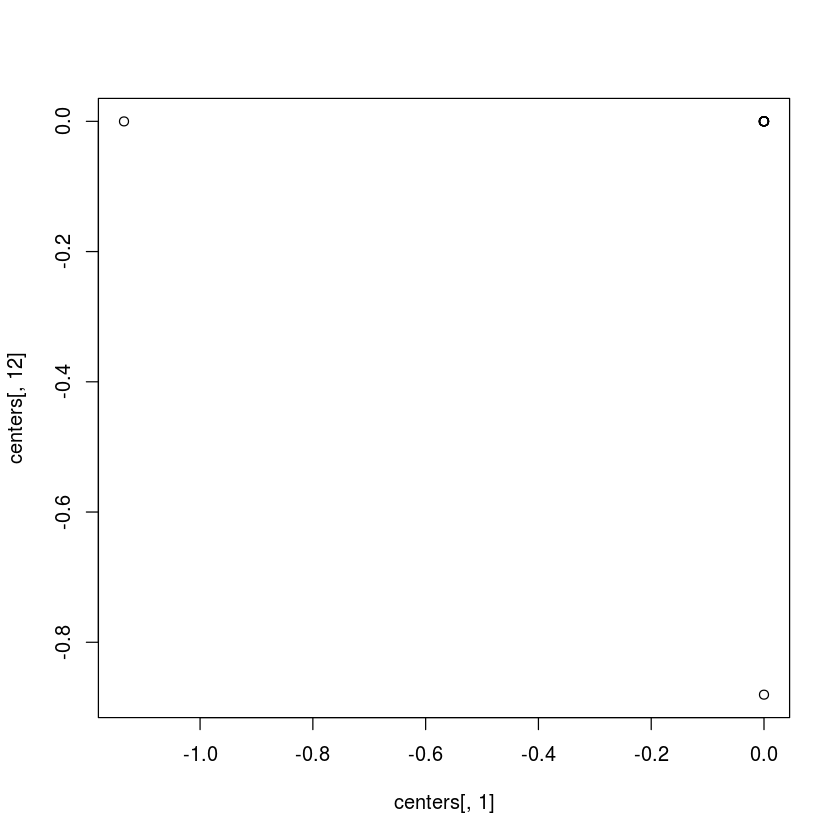

In [53]:
clustering <- fm.as.vector(res7$cluster)
centers <- as.matrix(fm.groupby(data, 2, fm.as.factor(clustering), "+")/as.matrix(cnt7))
centers
plot(x=centers[,1], y=centers[,12])

In [67]:
r <- sqrt(fm.agg.mat(data * data, 1, "+"))
data1 <- data[r > 1/sqrt(svals[1]), ]
dim(data1)
1/sqrt(svals[1])

[1] 9006457      22

[1] 0.008631632

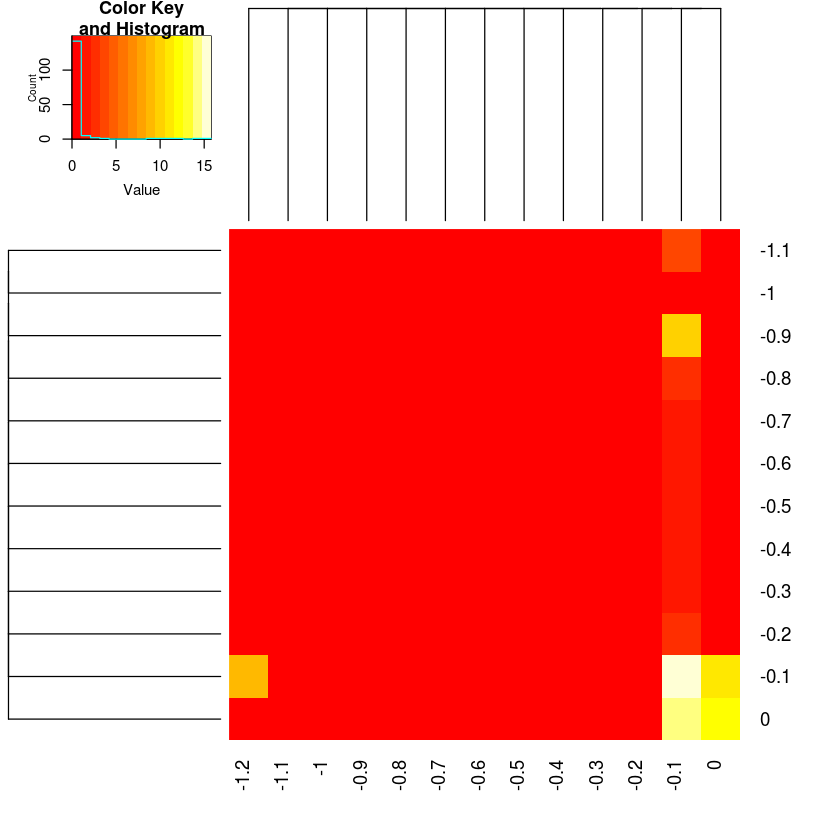

In [68]:
coo1 <- data1[,c(1, 12)]
fm.heatmap(coo1, 10, logval=TRUE)

In [72]:
library(fpc)
pamout <- pamk(as.matrix(data1), krange=2:20, usepam=FALSE, critout=TRUE)

2  clusters  0.9377405 
3  clusters  0.8954602 
4  clusters  0.8649369 
5  clusters  0.8511296 
6  clusters  0.8917175 
7  clusters  0.9252791 
8  clusters  0.9233828 
9  clusters  0.9197579 
10  clusters  0.9071991 
11  clusters  0.8428327 
12  clusters  0.6963791 
13  clusters  0.6876293 
14  clusters  0.7106015 
15  clusters  0.6854852 
16  clusters  0.6865931 
17  clusters  0.6189935 
18  clusters  0.6873614 
19  clusters  0.7317706 
20  clusters  0.8067173 


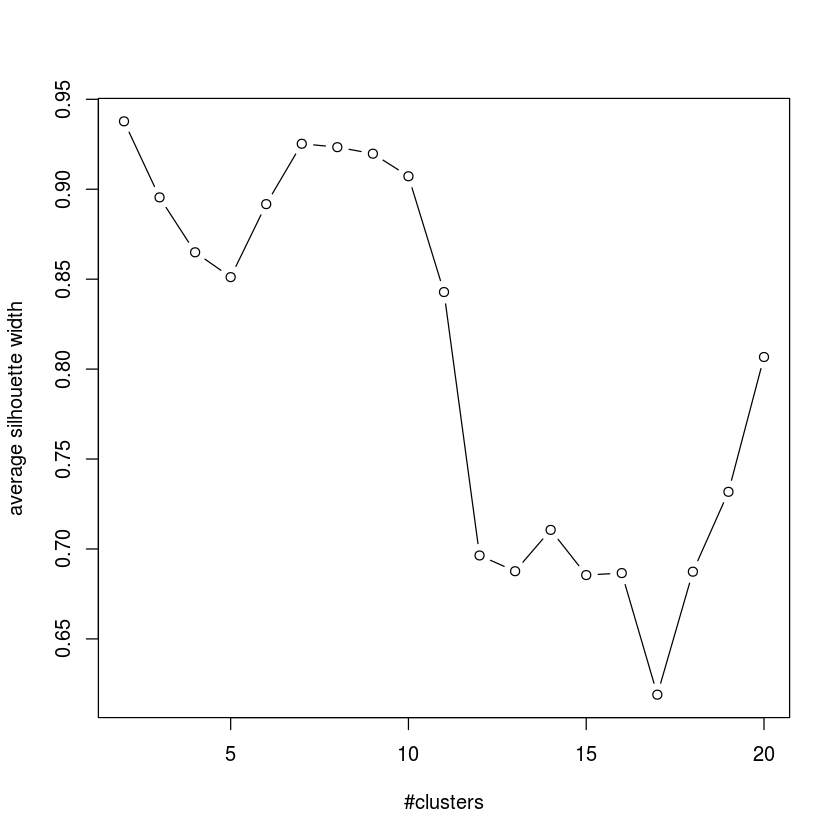

In [130]:
clus.val <- c(0.9377405,
0.8954602,
0.8649369,
0.8511296,
0.8917175,
0.9252791,
0.9233828,
0.9197579,
0.9071991,
0.8428327,
0.6963791,
0.6876293,
0.7106015,
0.6854852,
0.6865931,
0.6189935,
0.6873614,
0.7317706,
0.8067173)
plot(x=2:20, y=clus.val, type = "b", xlab="#clusters", ylab="average silhouette width")

In [86]:
library(ClusterR)

Loading required package: gtools

Attaching package: ‘gtools’

The following object is masked from ‘package:igraph’:

    permute



In [90]:
res7 <- KMeans_rcpp(as.matrix(data1), clusters=7, initializer="kmeans++")

In [138]:
cbind(1:ncol(res7$centroids), t(res7$centroids))

1,1.168708e-15,-9.050685e-12,-1.189924e-11,-6.775531e-06,-1.134895e+00,-8.788835e-17,-1.896928e-17
2,-2.499907e-10,-3.374971e-02,-4.435419e-02,-2.210492e-09,3.635575e-10,-1.349947e-12,-6.769417e-11
3,-2.872086e-16,2.357399e-13,2.901223e-13,-9.403084e-03,-3.685725e-16,5.887809e-16,-1.751112e-03
4,-1.237655e-15,5.954415e-15,9.680713e-15,-8.033330e-03,1.526545e-14,-2.084145e-15,-9.231420e-17
5,-2.506552e-14,-2.846089e-16,-1.409275e-15,3.011305e-03,-5.877713e-15,1.459368e-15,-2.863146e-17
6,-2.210899e-14,-5.942057e-12,-8.271736e-12,7.326615e-03,-4.056253e-15,4.468774e-16,-6.477943e-17
7,1.493861e-10,5.923701e-12,8.062548e-12,-5.783973e-03,3.420416e-13,-1.358110e-11,-2.600160e-12
8,-5.843039e-11,-2.675543e-16,2.476167e-15,-4.629270e-03,-4.958672e-14,5.321068e-12,1.016798e-12
9,-4.260464e-14,-3.387082e-12,1.362510e-12,-2.874905e-02,4.555576e-15,-1.149626e-01,-5.623341e-15
10,6.657615e-14,1.483171e-13,1.511283e-13,-8.180265e-03,4.869503e-16,2.497495e-15,-4.127566e-03
11,-2.370008e-01,4.808870e-11,6.869068e-11,-3.571700e-07,-1.875472e-14,1.198096e-14,-2.206366e-15


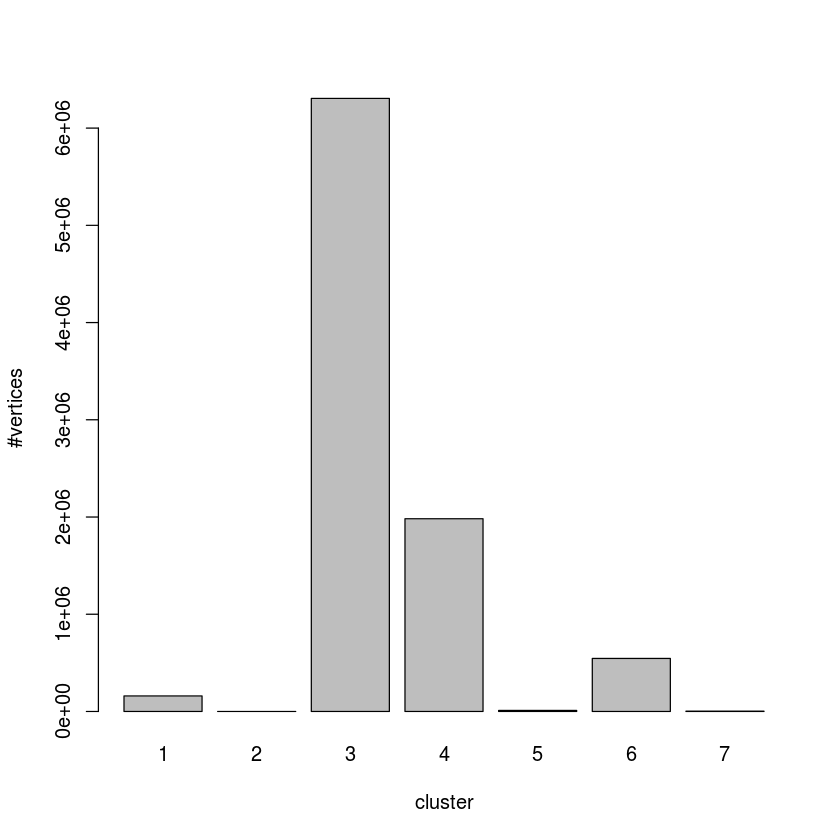

In [122]:
cnt7 <- table(res7$cluster)
barplot(cnt7, xlab="cluster", ylab="#vertices")

1.168708e-15,-2.499907e-10,-2.872086e-16,-1.237655e-15,-2.506552e-14,-2.210899e-14,1.493861e-10,-5.843039e-11,-4.260464e-14,6.657615e-14,⋯,-1.980431e-11,-2.134043e-17,-8.350307e-17,-1.664822e-15,-1.372930e-15,9.122380e-12,-3.567720e-12,-2.512394e-15,3.858338e-15,-1.353851e-02
-9.050685e-12,-3.374971e-02,2.357399e-13,5.954415e-15,-2.846089e-16,-5.942057e-12,5.923701e-12,-2.675543e-16,-3.387082e-12,1.483171e-13,⋯,-2.212804e+01,1.466221e-10,4.080935e-12,-6.021927e-13,-3.259601e-09,3.187887e-09,1.550220e-12,5.505478e-10,7.502469e-11,2.465106e-08
-1.189924e-11,-4.435419e-02,2.901223e-13,9.680713e-15,-1.409275e-15,-8.271736e-12,8.062548e-12,2.476167e-15,1.362510e-12,1.511283e-13,⋯,-2.426684e-05,-5.682776e-15,-4.806552e-18,2.455760e-18,-4.045653e-15,-3.567933e-15,4.228591e-17,-6.990837e-16,-1.134720e-14,-6.624638e-14
-6.775531e-06,-2.210492e-09,-9.403084e-03,-8.033330e-03,3.011305e-03,7.326615e-03,-5.783973e-03,-4.629270e-03,-2.874905e-02,-8.180265e-03,⋯,-4.373412e-06,-3.757216e-03,-7.732225e-03,2.894913e-03,4.673225e-03,-3.812740e-03,-4.420132e-03,-4.102564e-04,2.327901e-05,-3.657845e-06
-1.134895e+00,3.635575e-10,-3.685725e-16,1.526545e-14,-5.877713e-15,-4.056253e-15,3.420416e-13,-4.958672e-14,4.555576e-15,4.869503e-16,⋯,-4.868300e-13,1.112309e-18,-4.842981e-19,-9.175190e-19,-7.760802e-19,-1.487823e-14,5.813658e-15,-1.093504e-17,-1.257093e-18,-5.259568e-18
-8.788835e-17,-1.349947e-12,5.887809e-16,-2.084145e-15,1.459368e-15,4.468774e-16,-1.358110e-11,5.321068e-12,-1.149626e-01,2.497495e-15,⋯,-3.614945e-14,1.511436e-17,-4.917477e-17,3.419882e-17,1.004189e-17,-2.983319e-13,1.168755e-13,-2.451079e-03,5.199864e-17,2.460123e-16
-1.896928e-17,-6.769417e-11,-1.751112e-03,-9.231420e-17,-2.863146e-17,-6.477943e-17,-2.600160e-12,1.016798e-12,-5.623341e-15,-4.127566e-03,⋯,-4.287678e-12,-1.790165e-02,2.917570e-15,-8.907085e-15,-2.054985e-15,-1.183565e-09,4.628065e-10,1.091570e-14,-1.792429e+00,-6.741648e-13


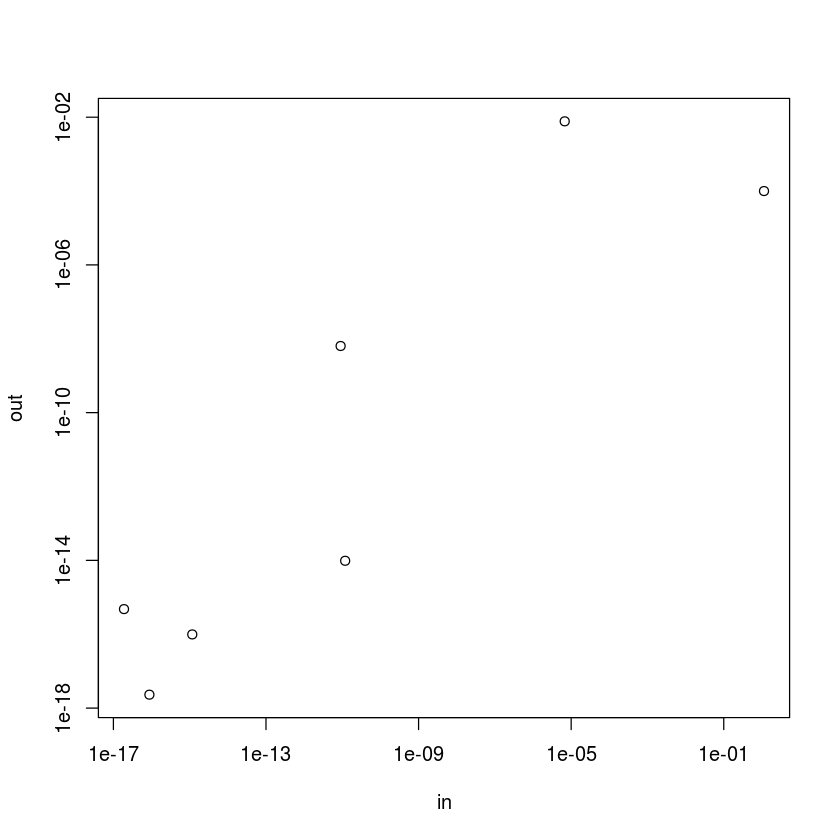

In [121]:
clustering <- fm.as.vector(res7$cluster)
centers <- as.matrix(fm.groupby(data1, 2, fm.as.factor(clustering), "+")/as.matrix(cnt7))
centers
plot(x=abs(centers[,1]), y=abs(centers[,12]), log="xy", xlab="in", ylab="out")

In [118]:
centers[,c(1, 12)]

1.168708e-15,9.891101e-17
-9.050685e-12,-6.378063e-09
-1.189924e-11,-9.754111e-15
-6.775531e-06,-7.725191e-03
-1.134895e+00,-1.000841e-04
-8.788835e-17,-2.312305e-18
-1.896928e-17,-4.796701e-16


In [133]:
tmp <- fm.conv.store(data1, in.mem = FALSE, name = "pg-Xhat-L.mat")

In [92]:
kmeans_cv <- function(data, range) {
    best.res <- KMeans_rcpp(data, clusters=range[1], initializer="kmeans++")
    ret <- distcritmulti(data, best.res$cluster)
    best.val <- ret$crit.overall
    for (k in range[2:length(range)]) {
        res1 <- KMeans_rcpp(data, clusters=k, initializer="kmeans++")
        ret <- distcritmulti(data, best.res$cluster)
        cat(k, "clusters:", best.res$cluster, "\n")
        if (best.val < ret$crit.overall) {
            best.res <- res1
            best.val <- ret$crit.overall
        }
    }
    best.res
}

pamout <- kmeans_cv(as.matrix(data1), range=2:20)

ERROR: Error: cannot allocate vector of size 3021.8 Gb
